# Classfication of Mushroom Edibility

## Problem Statement
> **Develop a Classfication Model to Predict If A Given Mushroom Is Safe For Consumption**

We want an accurate model that can be used in the field to help people determine if a gilled mushroom is edible.

![](https://ids-mushroom.appspot.com/images/Overview%20of%20Mushroom%20Attributes_inverted.png)
### What does human level performance look like for this problem? 
In a article published in Feburary 2020, the [US Agricultural Research Service developed a portable test](https://www.mdpi.com/2072-6651/12/2/123/htm) to detect if a mushroom is poisonous.

| Accuracy | True Positive Rate (Recall) | True Negative Rate |
|----|----|----|
| 94.6% | 92.3% | 100% |

Since we want a model that can be easily used in the field, and without any lab equipment, we will make this test as the benchmark to match/beat.
## Evaluation Metrics

### Optimizing Metric 
In this problem, it is far more important that our model has a high positive predictive power as we care more about detecting if a mushroom is poisonous than if it is edible. Hence, we aim to make use of a classification metric that heavily penalizes our model for making false negatives.
#### F2 Score
The $F_2$ Score is defined as follows:
$$
F_2 = 5 * \frac{precision*recall}{(4 * precision) + recall} = \frac{TP}{TP + 0.2*FP + 0.8FN}
$$

The F2 measure is a single number that summarizes the precision and recall of a model, placing more emphasis on the recall of the model (as compared to F1). Since recall (the ability of a model to predict the positive class) is more important in this problem, an F2 Score would be a more useful indicator of the utility of a candidate model. 
### Satisficing Metrics

#### Model Interpretibility
Given that the objective of the model is to help decide if a mushroom is poisonous, it is important that the human using the model is able to understand why the model has made a certain prediction, for him to make a final decision. Hence, the model used must not be a black box, but rather expose the factors that affect the final prediction. This means that we will avoid black box models such as ANNs, and prefer models like Logistic Regression or Decision Trees.

#### Overall Accuracy
Although we seek to maximize the $F_2$ score, the overall model should have an accuracy **above 95%** as we want the model to also be relatively good at predicting the negative class.

## Importing Libraries

In [234]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import phik
import json
from tqdm import tqdm
sns.set()

# Experimental
from sklearn.experimental import enable_halving_search_cv

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, make_scorer, fbeta_score
from yellowbrick.model_selection import learning_curve, feature_importances
from yellowbrick.classifier import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer


# Models
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV
from yellowbrick.model_selection import validation_curve

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, chi2, mutual_info_classif

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

## Data Ingestion
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [2]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("data/agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [3]:
with open('data/value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Exploration

In [4]:
mush_eda = mush_df.copy()

### Univariate Analysis

#### Descriptive Statistics

In [5]:
mush_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

We note that all features are nominally valued categorical features. Only stalk-root has missing values, with around 37.5% of the rows having stalk root as missing. We will need to investigate this more later to determine why the value is missing.

In [11]:
descriptive_stats = mush_eda.describe().T
descriptive_stats["Proportion of Most Frequent Value"] = descriptive_stats["freq"] / len(mush_eda) * 100
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,Proportion of Most Frequent Value
veil-type,8124,1,partial,8124,100.0
veil-color,8124,4,white,7924,97.538159
gill-attachment,8124,2,free,7914,97.415066
ring-number,8124,3,one,7488,92.171344
gill-spacing,8124,2,close,6812,83.85032
gill-size,8124,2,broad,5612,69.079271
stalk-surface-above-ring,8124,4,smooth,5176,63.712457
stalk-surface-below-ring,8124,4,smooth,4936,60.758247
bruises?,8124,2,f,4748,58.444116
stalk-shape,8124,2,tapering,4608,56.720827


From looking at the most frequent value of each column, we note that:
- most mushrooms are edible, and the classes appear to be balanced
- `veil-Type` has only a single value for all observations. 
- `gill-color` is the most varied feature, with 12 unique values, followed by `cap-color` with 10 values 
- almost all mushrooms have a white colored veil 

#### Target Label
Our target label is the `class` column. It is a binary column with two values:
- `edible`: Mushroom is safe to eat
- `poisonous`: Mushroom is of dubious edibility or straight up poisonous

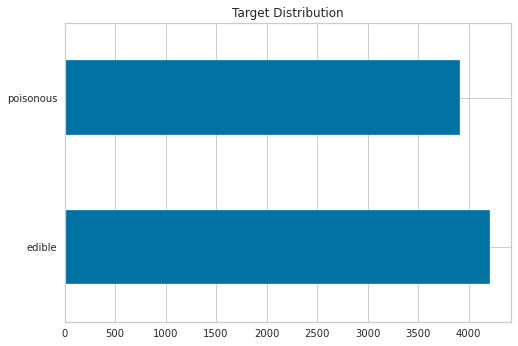

In [18]:
ax = mush_eda["class"].value_counts().plot(kind='barh', title="Target Distribution")

As we can see, the class distribution is relatively balanced, with most mushrooms being edible. Slightly less mushrooms are poisonous.

#### Features

In [20]:
def cat_plot(df, features, hue = None, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize= figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        counts = df[feature].value_counts().sort_values(ascending=False)
        if hue is None:
            sns.countplot(data = df, y = feature, ax = ax[idx], order= counts.index)
        else:
            sns.countplot(data = df, y = feature, hue= hue, ax = ax[idx], order= counts.index)
    return fig

##### General Features
There are some features which seem to have similar appearances, and hence may be confused for each other:
- Spore Print Color: Black, Brown and Chocolate
- Odor: Foul, Fishy, Pungent, Musty
- Population: {Several, Scattered}, {Numerous, Abudant, Clustered}
###### Spore Print Color
![](media/spore_print_capture.PNG)
- The spore print is the powdery deposit obtained by allowing spores of the mushroom to fall onto a surface underneath. 
- It is an essential clue to the identity of many species of mushrooms. 
- Individual spores are too small to be visible without a microscope. Hence other techniques must be used to obtain this data.
- One way is to cut off the head of the mushroom, and place it with the gills (below the cap) facing downward on a white sheet of paper. 
- Another way is to look for faint traces of color on the ground from nearby spores. 

###### Bruises
- Bruises are spots of color (usually blue or black) on the mushroom (usually on the underside or stem). 
- We can check for bruises by cutting/scratching off the top and bottom of the cap and observing for any color change.

###### Odor
- An odor is the smell a mushroom gives off. 
- It is usually faint, but may be detected by crushing the flesh between your fingers. 

###### Population & Habitat
![](media/pop.PNG)
- Population refers to the number of mushrooms in the area. Some mushrooms grow in big groups, while some mushrooms are isolated
- Habitat refers to the environment in which the mushroom is found in.

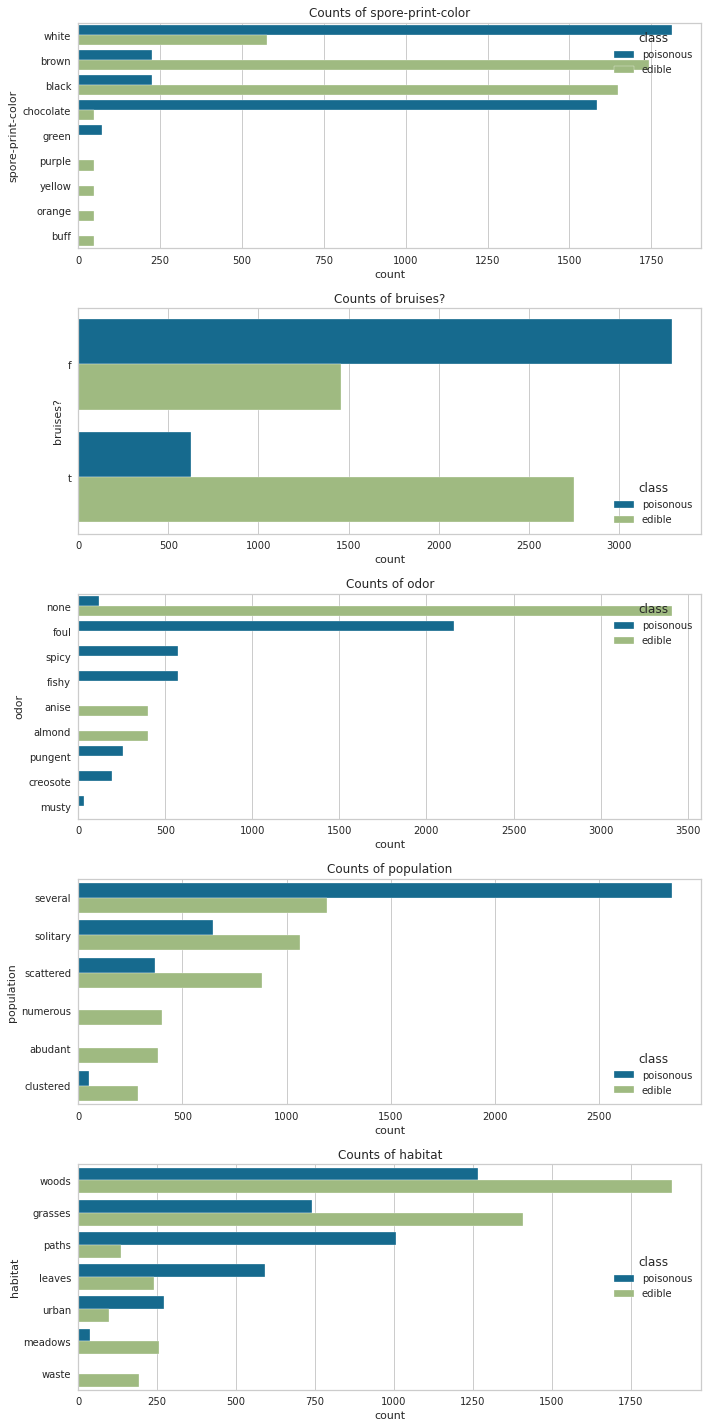

In [22]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']

fig = cat_plot(mush_eda, general_features, "class")

fig.show()

We note a few things about the general features of mushrooms:
- Most mushrooms have either white or dark looking spores. 
- Most mushrooms have no odor, and those mushrooms tend to be edible.
- It seems that mushrooms with a bad smell in general would tend to be poisonous
- Most mushrooms grow in the woods, followed by in grass land
- Most mushrooms don't have bruises.


##### Mushroom Caps
The cap is the head, and most visible part of the mushroom.
###### Cap Shape
The cap shapes of gill mushrooms look like this

![](media/cap_shape.PNG)


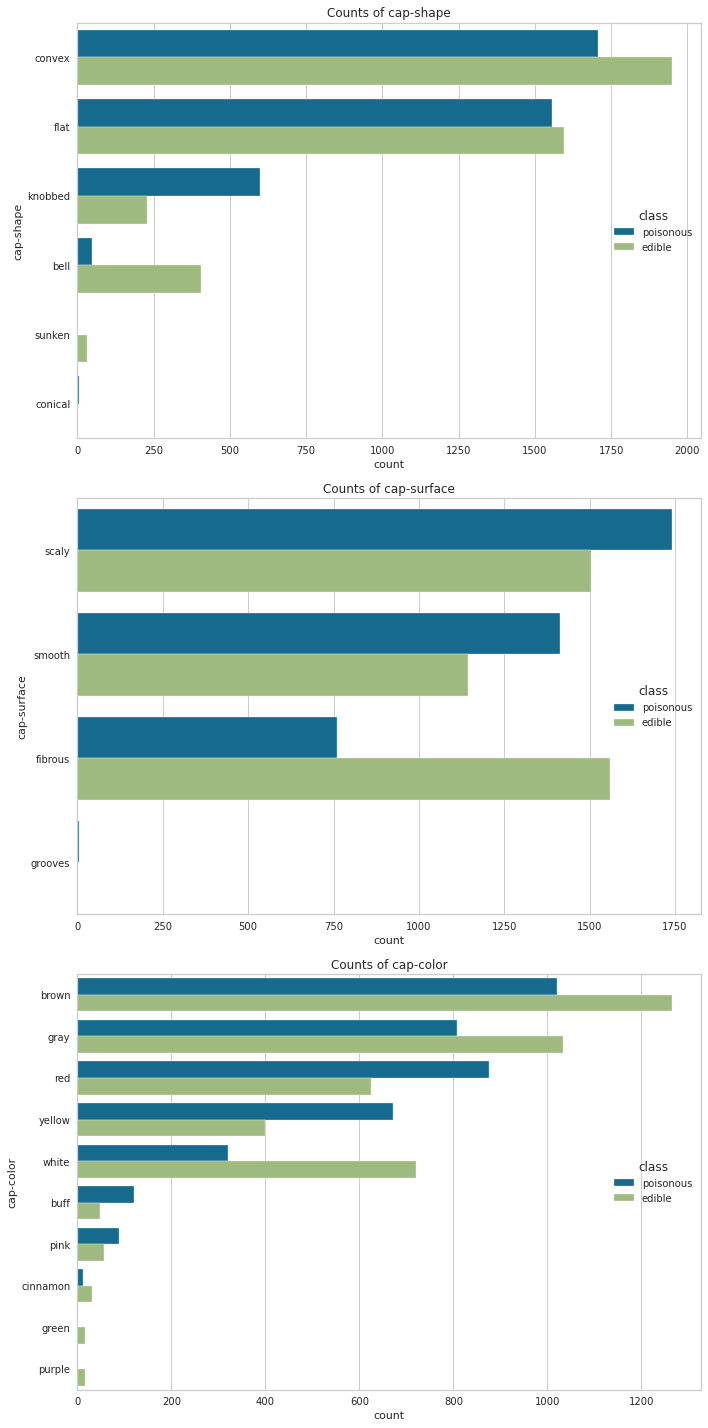

In [23]:
cap_features = ['cap-shape', 'cap-surface', 'cap-color']
fig = cat_plot(mush_eda, cap_features, "class")
fig.show()

- Most mushrooms are convexed shape (round head)
- For cap surface, almost no mushrooms have a grooved surface.
- For most mushrooms, cap color and shape does not seem to have much impact on its edibility as shown by the close porportion of classes for the top most common values
- Most of the unique variations in cap shape and color are relatively distinct in appearance.

##### Gills
- It is the part of the mushroom under the cap.

###### Gill Attachment
Refers to the way in which the gill is attached to the cap.

![](https://www.mushroomexpert.com/images/kuo6/glossary_gills_02.jpg)

###### Gill Spacing
Refers to the space between each gill 

![](https://www.mushroomexpert.com/images/kuo6/glossary_gills_03.jpg)

###### Gill Size
- Refers to the size of each individual gill 


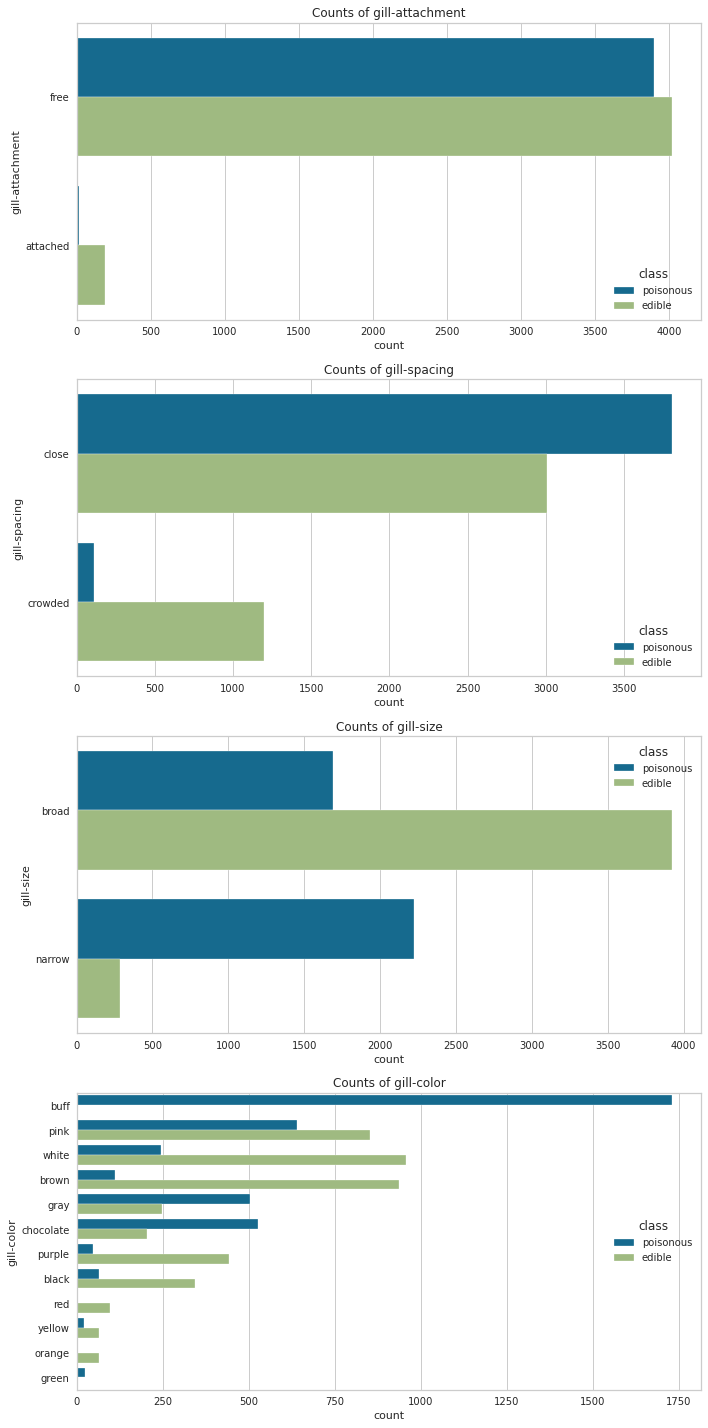

In [25]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
fig = cat_plot(mush_eda, gill_features, "class")

fig.show()

- Most gills are attached freely to the cap. Since it can be hard to distinguish whether or not a gill is freely attached or broadly attached, the feature may not be practical to collect in the field
- Similarly, a close and crowded gill spacing may be harder to distinguish.
- Most gills are broad, and close together.
- Most gills have a buff color, which looks similar to yellow.

##### Stalk
###### Stalk Shape
![](media/stalkshape.PNG)

###### Stalk Surface
![](media/stalk_surface.PNG)

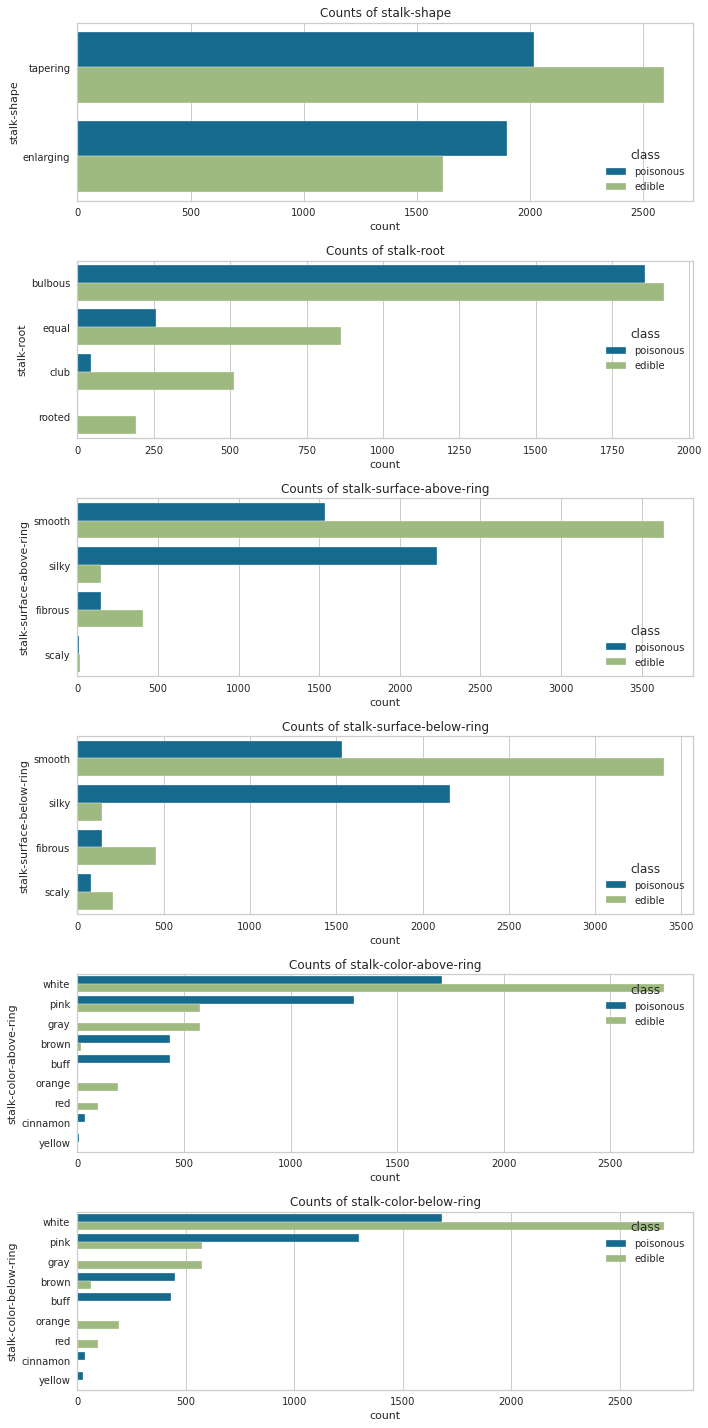

In [26]:
stalk_features = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']
fig = cat_plot(mush_eda, stalk_features, "class")

fig.show()

- Most mushrooms have a tapering stalk shape
- The roots of most mushrooms are bulbous (resembles a bulb)
- Most stalks have a smooth surface above and below the ring and are white or pink in color

##### Veil
A veil is the part that covers the cap and stalk of an immature mushroom.

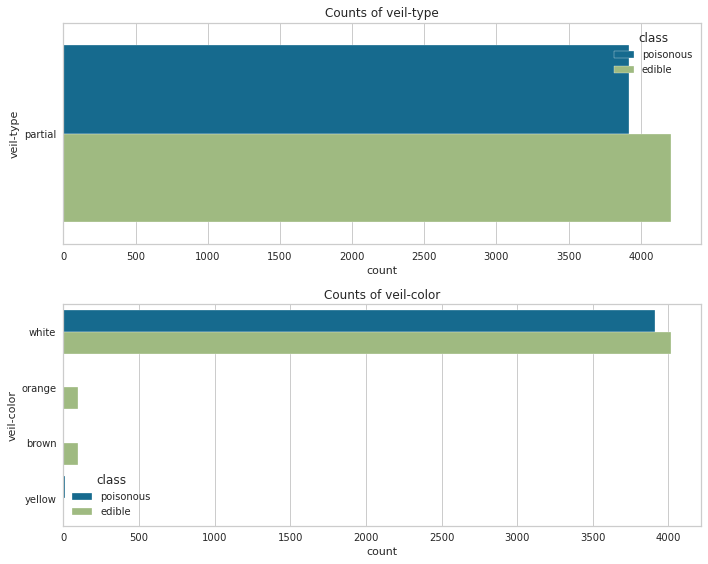

In [28]:
veil_features = ['veil-type', 'veil-color']
fig = cat_plot(mush_eda, veil_features, "class", figsize=(10, 8))

fig.show()

- Veil features are not that interesting, as there is only one type of veil in the data, and most veil are white in color

##### Ring
The ring is a remmant of a partial veil on the stalk.
![](http://ids-mushroom.appspot.com/images/mushroom%20wireframes_Mushroom%20Veils.png)

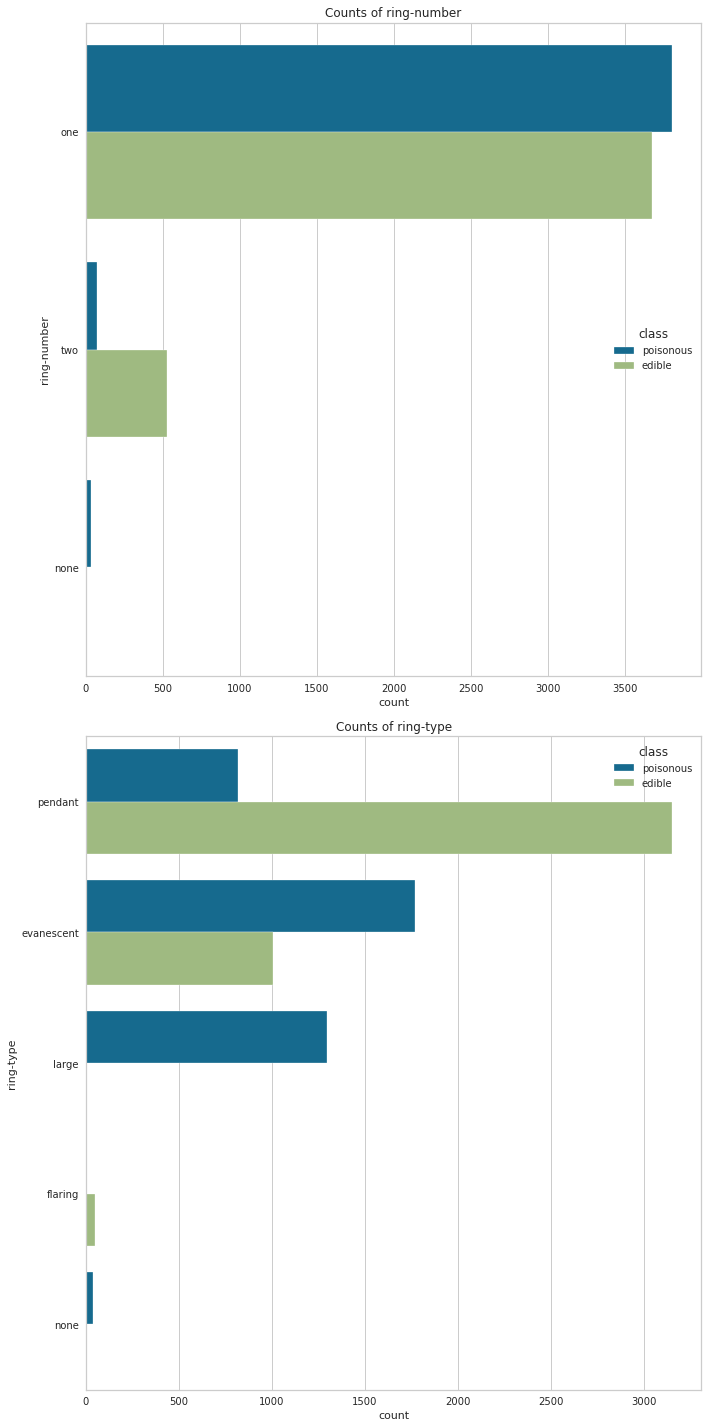

In [29]:
ring_features = ['ring-number',
       'ring-type']
fig = cat_plot(mush_eda, ring_features, "class")

fig.show()

- Most mushrooms have a single ring which comes down from the bottom of the cap (like a pendant)

### Bivariate Analysis
To check correlation between the features and target, we make use of $\phi_k$ correlation, which has native support for nominal variables. The reason why we choose this over other measures of correlation like Pearson's r or $\chi^2$ is because:
- For a $\chi^2$ test, when the degrees of freedom is extremely high (as is the case when we have so many features), the chi squared values tend to be extremely large. Hence it becomes harder to interpret the values obtained as every feature would appear important.
- While Pearson correlation can calculate correlation between dichotomous categorical variables, it has been mostly designed for interval variables. To calculate correlation for nominal categorical variables, we need to one hot encode the data, which would make the resulting correlation plot extremely hard to read due to it's large size 

In [30]:
phik_matrix = mush_eda.phik_matrix()

/home/tiencheng/anaconda3/envs/data_sci_base_v1_2021/lib/python3.9/site-packages/phik/data_quality.py:78: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  warnings.warn(


In [31]:
by_class_correlation = phik_matrix.sort_values("class", ascending=False) 

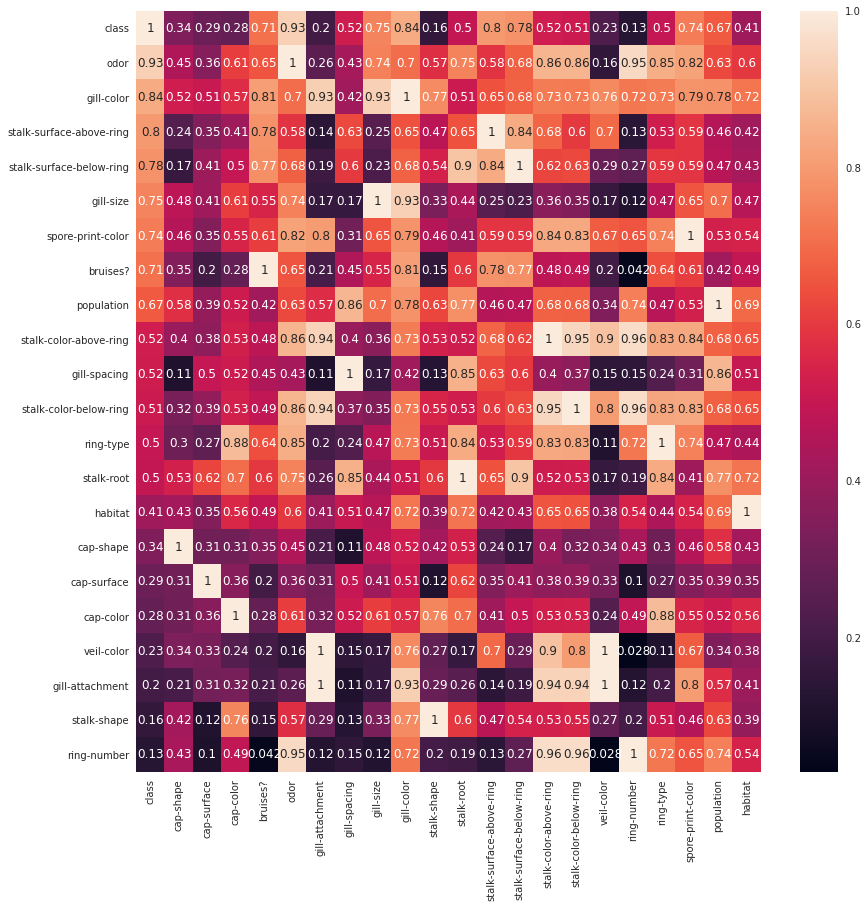

In [35]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(by_class_correlation, annot=True, ax = ax)
fig.show()

Based off the correlation heatmap, we note a few things:
- The features with greatest correlation with class are odor, gill-color, stalk surface, gill size and spore print color 
- Many features are correlated with each other. This suggests there is a lot of redundant information in the data, and that we would benefit from feature selection.

In [45]:
pd.crosstab(mush_eda["class"], mush_eda["odor"])

odor,almond,anise,creosote,fishy,foul,musty,none,pungent,spicy
class,,,,,,,,,
edible,400,400,0,0,0,0,3408,0,0
poisonous,0,0,192,576,2160,36,120,256,576


In [46]:
pd.crosstab(mush_eda["class"], mush_eda["gill-color"])

gill-color,black,brown,buff,chocolate,gray,green,orange,pink,purple,red,white,yellow
class,,,,,,,,,,,,
edible,344,936,0,204,248,0,64,852,444,96,956,64
poisonous,64,112,1728,528,504,24,0,640,48,0,246,22


In [48]:
pd.crosstab(mush_eda["class"], mush_eda["stalk-surface-above-ring"])

stalk-surface-above-ring,fibrous,scaly,silky,smooth
class,,,,
edible,408,16,144,3640
poisonous,144,8,2228,1536


In [49]:
pd.crosstab(mush_eda["class"], mush_eda["gill-size"])

gill-size,broad,narrow
class,,
edible,3920,288
poisonous,1692,2224


In [50]:
pd.crosstab(mush_eda["class"], mush_eda["spore-print-color"])

spore-print-color,black,brown,buff,chocolate,green,orange,purple,white,yellow
class,,,,,,,,,
edible,1648,1744,48,48,0,48,48,576,48
poisonous,224,224,0,1584,72,0,0,1812,0


### Missing Value Analysis
During our initial view of the data, we noted that there were missing value for `stalk-root`. We will do some further analysis to investigate the cause of the missing data.

In [39]:
mush_eda["is_missing"] = mush_eda["stalk-root"].isna()

In [41]:
mush_eda.phik_matrix()["is_missing"].sort_values(ascending=False)

/home/tiencheng/anaconda3/envs/data_sci_base_v1_2021/lib/python3.9/site-packages/phik/data_quality.py:78: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  warnings.warn(


is_missing                  1.000000
gill-color                  0.969058
spore-print-color           0.892554
gill-size                   0.810669
population                  0.680674
cap-shape                   0.656794
bruises?                    0.654741
cap-color                   0.652780
odor                        0.634615
habitat                     0.552930
cap-surface                 0.539702
ring-type                   0.534035
class                       0.456156
stalk-color-above-ring      0.432789
stalk-color-below-ring      0.432273
stalk-surface-above-ring    0.358439
veil-color                  0.351362
gill-attachment             0.330312
stalk-surface-below-ring    0.329581
stalk-shape                 0.268008
ring-number                 0.185846
gill-spacing                0.126278
stalk-root                       NaN
Name: is_missing, dtype: float64

We note that the presence or absence of a stalk root property is strongly correlated with the gill color and spore-print color. This suggests that the values are not missing at random, but rather indicate some species of mushroom without a stalk-root. 

## Data Preparation

### Separate Target Label and Features

In [75]:
X, y = mush_df.drop('class', axis = 1), mush_df["class"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [197]:
list(zip(label_encoder.inverse_transform(y), y))[:4]

[('poisonous', 1), ('edible', 0), ('edible', 0), ('poisonous', 1)]

### Create Hold Out Set

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, shuffle=True,random_state = random_state)

### Data Preprocessing Pipeline
#### Missing Value Imputation
- We choose to impute the missing values for stalk-root and add an indicator that the value is missing 
#### Encoding Categorical Columns
- Since all the columns are nominally valued, we will perform one hot encoding on the categorical values.

In [123]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)), # impute missing values with most frequent value
    ('Encoding Categorical Variables', OneHotEncoder(handle_unknown='ignore'))
]

data_preprocess_transformer = Pipeline(data_preprocess_steps)
data_preprocess_transformer.fit_transform(X_train)

<6499x118 sparse matrix of type '<class 'numpy.float64'>'
	with 149477 stored elements in Compressed Sparse Row format>

## Modelling

### Evaluation Methodology
- Given the small size of the dataset in comparison to the number of one hot encoded features, any model used would be highly prone to overfitting.
- We will use a strategy of k-Fold Cross Validation to select our candidate models.
- Although it would be preferable to have a hold out set outside of cross validation to evaluate the final model, due to the small dataset size, this may not be feasible.  

In [180]:
f2_score = make_scorer(fbeta_score, beta = 2)
metrics = {
    "f2" : f2_score,
    "accuracy" : "accuracy",
    "recall" : "recall" 
}
def evaluate_candidate_model(clf, X, y, metrics = metrics, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is not None else type(clf).__name__
    single_metric = type(metrics) in { str, callable }
    scores = cross_validate(clf, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator, n_jobs= -1)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_f2"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    his_snapshot = scores.iloc[0, :]
    his_snapshot.rename(index=model_name, inplace=True)
    history = history.append(his_snapshot)
    lr = learning_curve(clf, X, y, scoring = f2_score, cv = cv, n_jobs=-1)
    return scores, history, lr, best_estimator if return_estimator else None

### Baseline Model

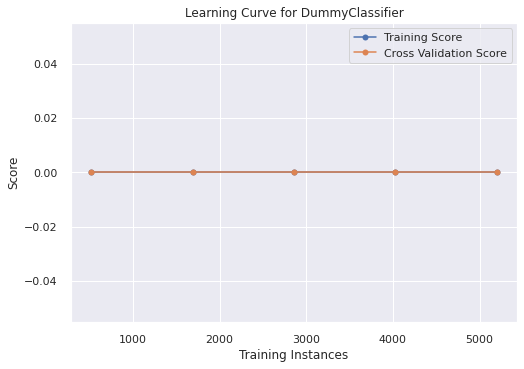

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.0,0.0,0.51793,0.51793,0.0,0.0
std,0.0,0.0,0.00035,0.00009,0.0,0.0


In [161]:
baseline = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', DummyClassifier())
])

scores, history, lr, _ = evaluate_candidate_model(baseline, X_train, y_train, model_name="Baseline")
display(scores)

### Logistic Regression

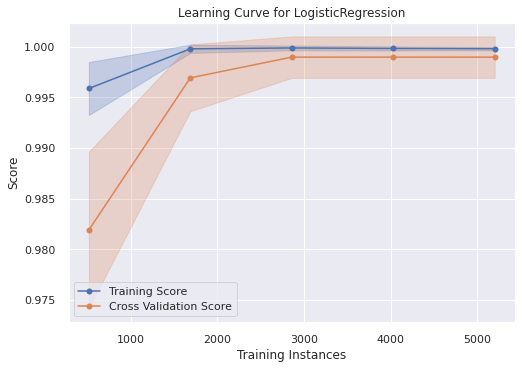

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99898,0.99981,0.99938,0.99988,0.99872,0.99976
std,0.00229,0.00017,0.00138,0.00011,0.00285,0.00022


In [162]:
logreg = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', LogisticRegression(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(logreg, X_train, y_train, history=history, model_name="Logistic Regression")
display(scores)

### Decision Tree

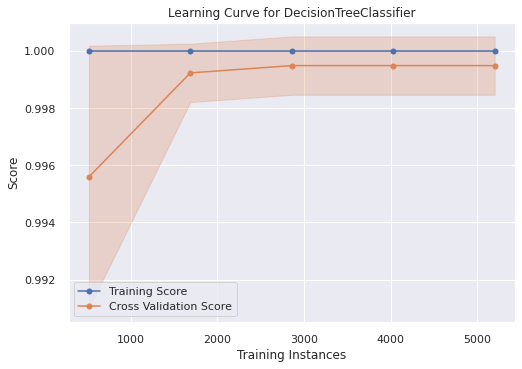

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99949,1.0,0.99969,1.0,0.99936,1.0
std,0.00114,0.0,0.00069,0.0,0.00143,0.0


In [163]:
dt = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', DecisionTreeClassifier(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(dt, X_train, y_train, history=history, model_name="Decision Tree")
display(scores)

### Random Forests

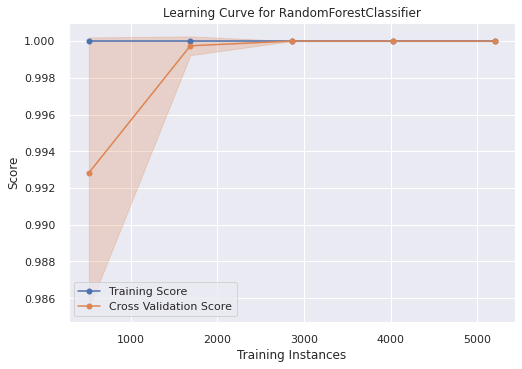

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
rf = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', RandomForestClassifier(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(rf, X_train, y_train, history=history, model_name="Random Forests")
display(scores)

### Support Vector Machines

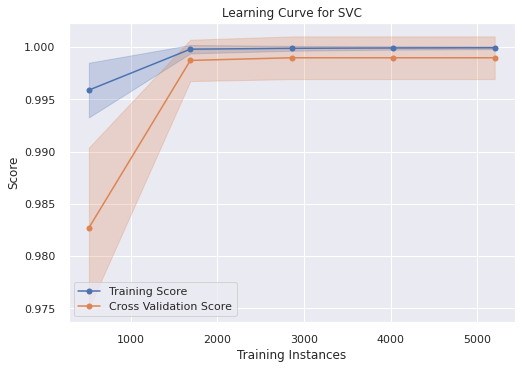

,test_f2,train_f2,test_accuracy,train_accuracy,test_recall,train_recall
mean,0.99898,0.99994,0.99938,0.99996,0.99872,0.99992
std,0.00229,0.00014,0.00138,0.00009,0.00285,0.00018


In [165]:
svm = Pipeline([
    ('Data Preprocessing', data_preprocess_transformer),
    ('Model', SVC(random_state=random_state))
])

scores, history, lr, _ = evaluate_candidate_model(svm, X_train, y_train, history=history, model_name="Support Vector Classifier")
display(scores)

## Model Evaluation

In [166]:
history.sort_values("test_f2", ascending=False)

,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
Random Forests,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
Decision Tree,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
Logistic Regression,0.99938,0.99898,0.99872,0.99988,0.99981,0.99976
Support Vector Classifier,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
Baseline,0.51793,0.00000,0.00000,0.51793,0.00000,0.00000


## Model Improvement

### Encoding Methodology
We attempt to improve the model performance further by attempting different methods of encoding the data

In [136]:
X_train.describe().T.sort_values("unique")

,count,unique,top,freq
veil-type,6499,1,partial,6499
bruises?,6499,2,f,3795
gill-attachment,6499,2,free,6337
gill-spacing,6499,2,close,5456
gill-size,6499,2,broad,4518
stalk-shape,6499,2,tapering,3678
ring-number,6499,3,one,5985
stalk-root,4531,4,bulbous,3049
cap-surface,6499,4,scaly,2570
veil-color,6499,4,white,6345


In [143]:
binary_columns = ["bruises?", "gill-attachment", "gill-spacing", "gill-size", "stalk-shape"]

In [144]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, colnames, binary_columns):
        self.colnames = colnames
        self.binary_columns = binary_columns
        self.cat_columns = [col for col in self.colnames if col not in self.binary_columns]
        self.ohe = ColumnTransformer([
            ('Binary Encoding', OneHotEncoder(drop='first'), self.binary_columns),
            ('One Hot Encoding', OneHotEncoder(handle_unknown='ignore'), self.cat_columns)
        ])
    def fit(self, X, y = None):
        X_df = pd.DataFrame(X, columns=self.colnames)
        self.ohe.fit(X_df)
        return self 
    def transform(self, X, y = None):
        X_df = pd.DataFrame(X, columns=self.colnames)
        return self.ohe.transform(X_df)
    def get_feature_names(self):
        return self.ohe[0].get_feature_names(self.binary_columns) + self.ohe[1].get_feature_names(self.cat_columns)

In [145]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)), # impute missing values with most frequent value
    ('Encoding Categorical Variables', CustomOneHotEncoder(list(X_train.columns) + ["stalk_root_isna"], binary_columns))
]

data_preprocess_transformer = Pipeline(data_preprocess_steps)
data_preprocess_transformer.fit_transform(X_train)

<6499x113 sparse matrix of type '<class 'numpy.float64'>'
	with 132725 stored elements in Compressed Sparse Row format>

  0%|          | 0/3 [00:00<?, ?it/s]

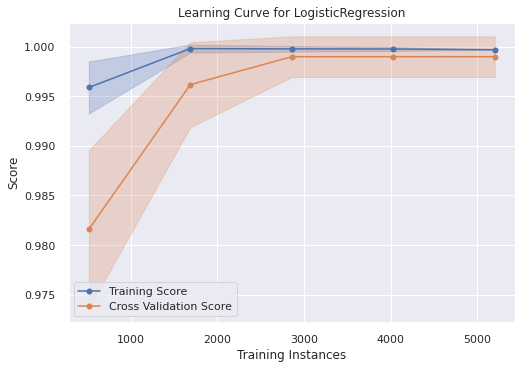

 33%|███▎      | 1/3 [00:03<00:07,  3.65s/it]

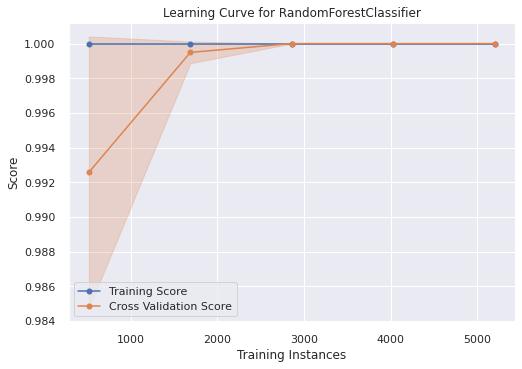

 67%|██████▋   | 2/3 [00:10<00:05,  5.42s/it]

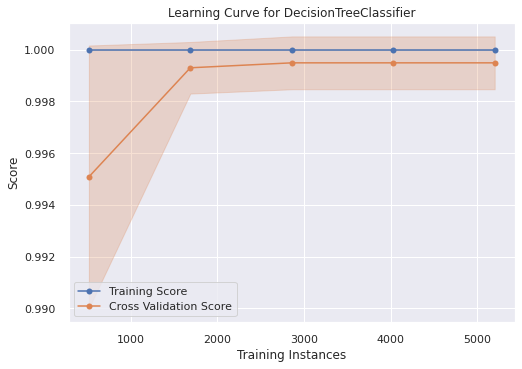

100%|██████████| 3/3 [00:13<00:00,  4.37s/it]


,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
Baseline,0.51793,0.00000,0.00000,0.51793,0.00000,0.00000
Logistic Regression,0.99938,0.99898,0.99872,0.99988,0.99981,0.99976
Decision Tree,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
Random Forests,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
Support Vector Classifier,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
Pipeline,NaN,NaN,NaN,NaN,NaN,NaN
Pipeline,NaN,NaN,NaN,NaN,NaN,NaN
Pipeline,NaN,NaN,NaN,NaN,NaN,NaN
LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN
RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
models = [LogisticRegression(random_state=random_state), RandomForestClassifier(random_state=random_state), DecisionTreeClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ('Data Preprocessing', data_preprocess_transformer),
        ('Model', model)
    ])
    scores, history, lr, _ = evaluate_candidate_model(model, X_train, y_train, history= history, model_name=model_name, return_learning_curve=True)

display(history)

We note that using binary encoding on variables with two unique values only does not have any significant impact on performance. Hence it is simpler to just one hot encode all the variables. 

While we could attempt other encoding methods like frequency encoding, such methods would not be easily interpretable by a human, thus we do not attempt such methods.

In [157]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)), # impute missing values with most frequent value
    ('Encoding Categorical Variables', OneHotEncoder(handle_unknown='ignore'))
]

data_preprocess_transformer = Pipeline(data_preprocess_steps)

### Feature Selection
While our models can perform well, the large number of features in the dataset means our models would be prone to overfitting. Hence, we want to reduce the dimensionality of our data through feature selection. We will attempt several methods of feature selection.

#### Selecting Via Model Coefficients
To reduce the number of features in our data, we make use of an L1 Regularized Logistic Regression model, which produces a set of sparse coefficients.

  0%|          | 0/3 [00:00<?, ?it/s]

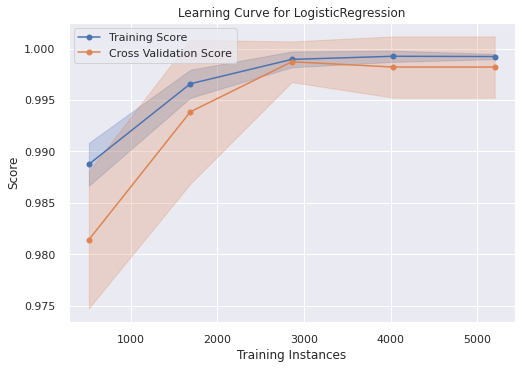

 33%|███▎      | 1/3 [00:02<00:04,  2.26s/it]

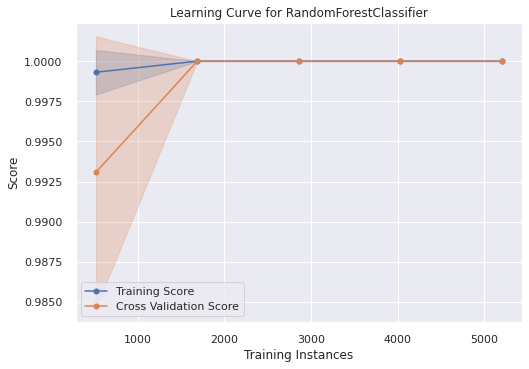

 67%|██████▋   | 2/3 [00:07<00:03,  3.75s/it]

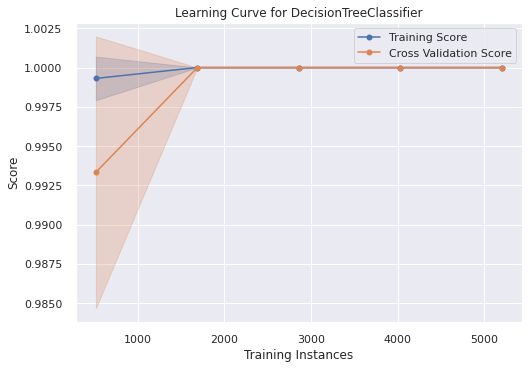

100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


,test_accuracy,test_f2,test_recall,train_accuracy,train_f2,train_recall
Baseline,0.51793,0.00000,0.00000,0.51793,0.00000,0.00000
Logistic Regression,0.99938,0.99898,0.99872,0.99988,0.99981,0.99976
Decision Tree,0.99969,0.99949,0.99936,1.00000,1.00000,1.00000
Random Forests,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
Support Vector Classifier,0.99938,0.99898,0.99872,0.99996,0.99994,0.99992
LogisticRegression (Sparse Coefficients),0.99892,0.99821,0.99777,0.99958,0.99930,0.99912
RandomForestClassifier (Sparse Coefficients),1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
DecisionTreeClassifier (Sparse Coefficients),1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [167]:
models = [LogisticRegression(random_state=random_state), RandomForestClassifier(random_state=random_state), DecisionTreeClassifier(random_state=random_state)]
for model in tqdm(models):
    model_name = type(model).__name__
    model = Pipeline([
        ('Data Preprocessing', data_preprocess_transformer),
        ('Feature Selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
        ('Model', model)
    ])
    scores, history, lr, _ = evaluate_candidate_model(model, X_train, y_train, history= history, model_name=f"{model_name} (Sparse Coefficients)", return_learning_curve=True)

display(history)

We note that after performing feature selection, our decision tree models are able to achieve 100% f2 and accuracy on cross validation. Given that this method of feature selection achieves good results, we will choose this method.

### Hyperparameter Tuning

To further reduce the complexity of our models, we will attempt hyperparameter tuning on a Decision Tree and the Logistic Regression Model used for feature selection. Since our model already has 100% accuracy, we will instead generate a series of validation curves first to determine how much the model can be simplified without having a large impact on the model performance.

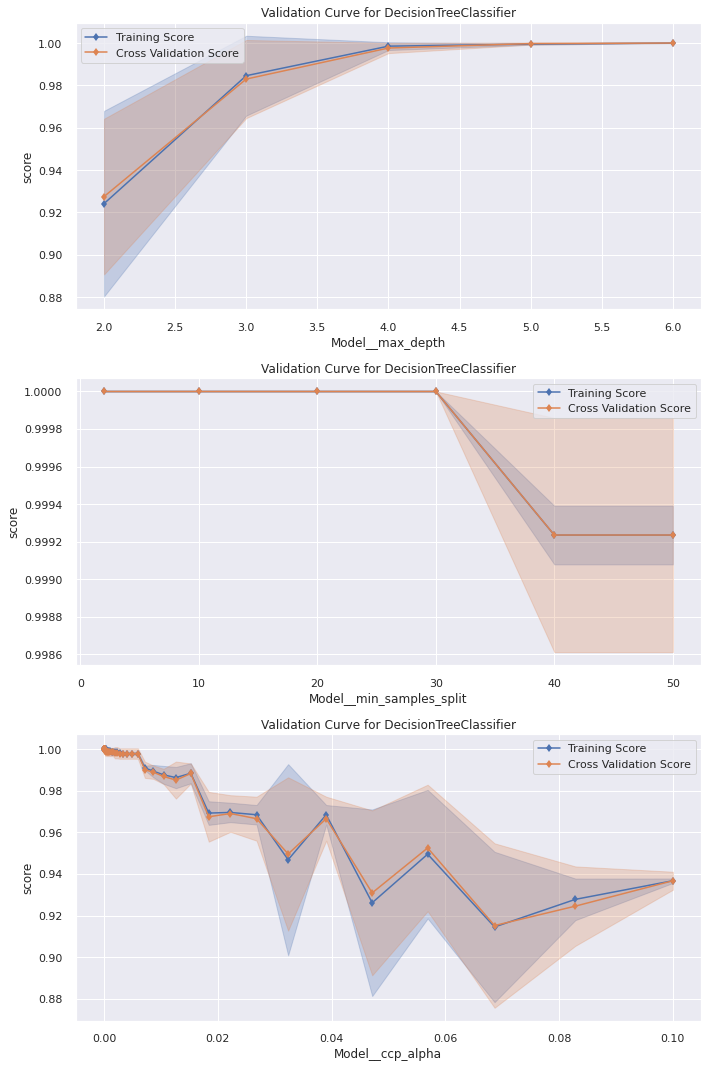

In [173]:
dt = Pipeline([
        ('Data Preprocessing', data_preprocess_transformer),
        ('Feature Selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
        ('Model', DecisionTreeClassifier())
    ])
param_grid = {
    "Model__max_depth" : [2, 3, 4, 5, 6],
    "Model__min_samples_split" : [2, 10, 20, 30, 40, 50],
    "Model__ccp_alpha" : np.logspace(-5, -1, 50)
}
fig, ax = plt.subplots(len(param_grid.keys()), 1, figsize= (10, 15), tight_layout=True)
for idx,(key, value) in enumerate(param_grid.items()):
    validation_curve(dt, X_train, y_train, param_name=key, param_range=value, scoring=f2_score, n_jobs=-1, ax = ax[idx], show=False)


- It seems that pruning the model further is not useful, since the model has already been highly simplified through feature selection
- A model with a max depth of 5 and above can obtain a perfect score, but a model with a max depth of 4 can attain very close, but not perfect results.

## Final Model
Our final model used will be a decision tree as shown below:

In [243]:
dt = Pipeline([
        ('Data Preprocessing', data_preprocess_transformer),
        ('Feature Selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
        ('Model', DecisionTreeClassifier(max_depth=5, min_samples_split=30))
    ])
dt.fit(X_train, y_train)

Pipeline(steps=[('Data Preprocessing',
                 Pipeline(steps=[('Imputer',
                                  SimpleImputer(add_indicator=True,
                                                strategy='most_frequent')),
                                 ('Encoding Categorical Variables',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('Feature Selection',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              solver='liblinear'))),
                ('Model',
                 DecisionTreeClassifier(max_depth=5, min_samples_split=30))])

### Model Evaluation

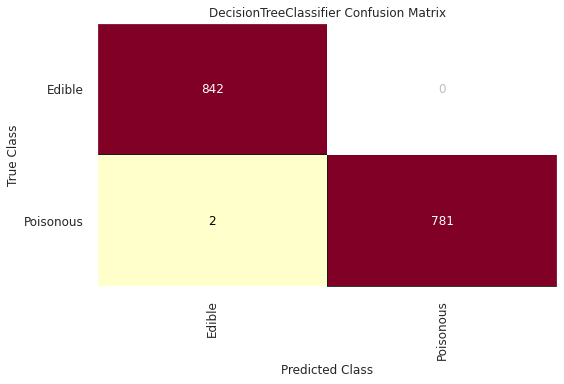

ConfusionMatrix(ax=<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x7f3f16e45670>,
                encoder={0: 'Edible', 1: 'Poisonous'},
                estimator=Pipeline(steps=[('Data Preprocessing',
                                           Pipeline(steps=[('Imputer',
                                                            SimpleImputer(add_indicator=True,
                                                                          strategy='most_frequent')),
                                                           ('Encoding '
                                                            'Categorical '
                                                            'Variables',
                                                            OneHotEncoder(handle_unknown='ignore'))])),
                                          ('Feature Selection',
   

In [244]:
y_pred = dt.predict(X_test)
confusion_matrix(dt, X_train, y_train, X_test, y_test, encoder = { 1 : "Poisonous", 0 : "Edible"})

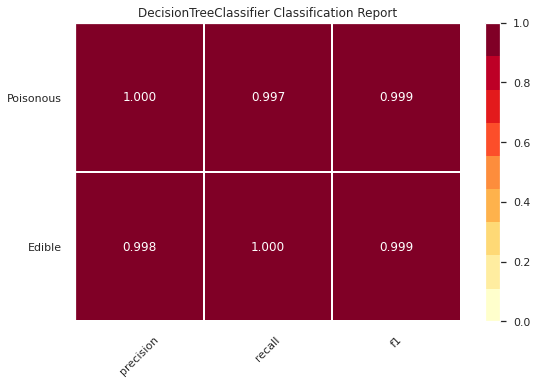

ClassificationReport(ax=<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f3f2727b310>,
                     encoder={0: 'Edible', 1: 'Poisonous'},
                     estimator=Pipeline(steps=[('Data Preprocessing',
                                                Pipeline(steps=[('Imputer',
                                                                 SimpleImputer(add_indicator=True,
                                                                               strategy='most_frequent')),
                                                                ('Encoding '
                                                                 'Categorical '
                                                                 'Variables',
                                                                 OneHotEncoder(handle_unknown='ignore'))])),
                                               ('Featu

In [245]:
classification_report(dt, X_train, y_train, X_test, y_test, encoder = { 1 : "Poisonous", 0 : "Edible"})

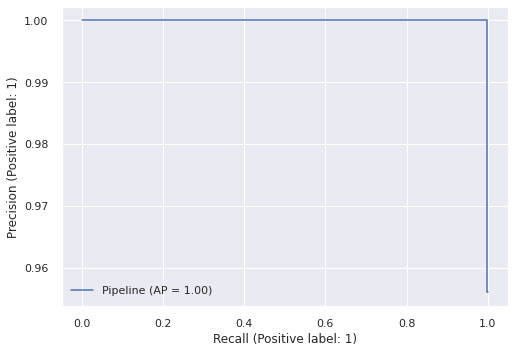

In [246]:
plot_precision_recall_curve(dt, X_test, y_test)

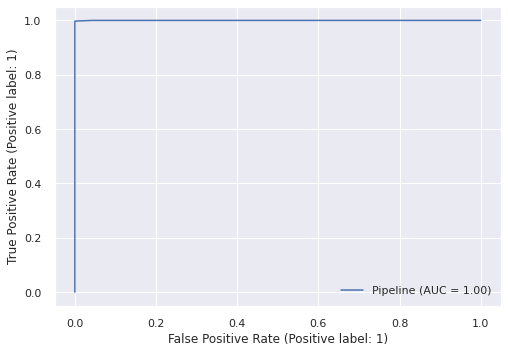

In [247]:
plot_roc_curve(dt, X_test, y_test)

### Feature Importances

In [248]:
labels = dt[0][1].get_feature_names(list(X_train.columns) + ["stalk_root_isna"])[dt[1].get_support()]

In [1]:
pd.DataFrame(data_preprocess_transformer.fit_transform(X_train), columns=labels)

NameError: name 'pd' is not defined

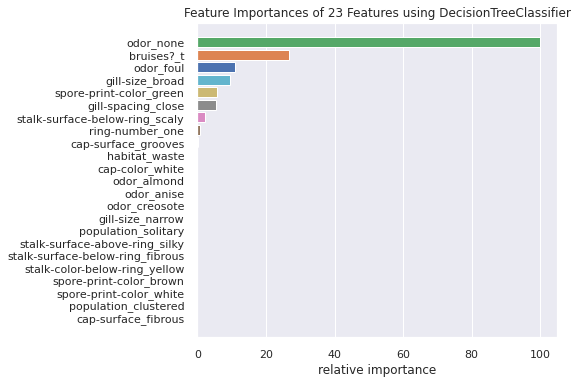

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 23 Features using DecisionTreeClassifier'}, xlabel='relative importance'>,
                   estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_split=30),
                   labels=array(['cap-surface_fibrous', 'cap-surface_grooves', 'cap-color_white',
       'bruises?_t', 'odor_almond', 'odor_anise', 'odor_creosote',
       'odor_foul..._close', 'gill-size_broad',
       'gill-size_narrow', 'stalk-surface-above-ring_silky',
       'stalk-surface-below-ring_fibrous',
       'stalk-surface-below-ring_scaly', 'stalk-color-below-ring_yellow',
       'ring-number_one', 'spore-print-color_brown',
       'spore-print-color_green', 'spore-print-color_white',
       'population_clustered', 'population_solitary', 'habitat_waste'],
      dtype=object))

In [249]:
feature_importances(dt[-1], X_train , y_train, labels = labels)

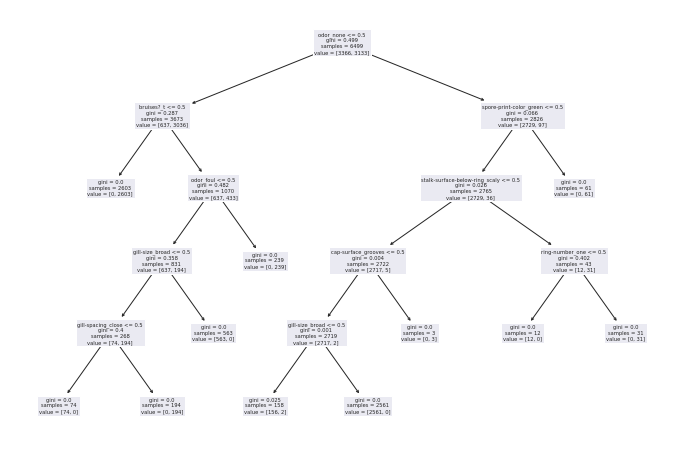

In [250]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(dt[-1], feature_names=labels)
fig.show()

## Summary